In [1]:
#import the picture
import cv2
import numpy as np

import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import pandas as pd

In [2]:

# Specify the file path of the image
image_path = "input_trial.jpg"

image_path = "frame_106.png"

# Read the image
image_input = cv2.imread(image_path)

# Check if the image was successfully read
if image_input is not None:
    # Image was read successfully
    print("Image read successfully!")
else:
    # Failed to read the image
    print("Failed to read the image.")

Image read successfully!


In [3]:
# import reference points
image_data_path = "input_trial.dat"
image_data_path = f"{image_path}.dat"

with open(image_data_path,"r") as f:
    reference_points = f.readlines()
    reference_points = [x.strip() for x in reference_points]
ds=np.array([ float(x) for x in reference_points[3:6]])
ps=np.array([ [float(y) for y in x.split()] for x in reference_points[0:3]])
h,w,_=image_input.shape
print(  f'{w=}, {h=}')
ps0=np.array([[(w-1)*0.5,(h-1)*0.5]]*3)
#c: float=int(reference_points[6])*w/36.0
c: float=float(reference_points[6])
ds,ps,ps0,c

w=1280, h=720


(array([0.21    , 0.363743, 0.297   ]),
 array([[776., 345.],
        [446., 258.],
        [888.,   5.]]),
 array([[639.5, 359.5],
        [639.5, 359.5],
        [639.5, 359.5]]),
 1036.39)

In [4]:
# copy image_input
image = image_input.copy()

# write 3 circles at ps on the image
for i in range(3):
    image = cv2.circle(image, (int(ps[i][0]), int(ps[i][1])), 25, (0, 0, 255), -1)

#write a line between the each pair of points
for i in range(3):
    image = cv2.line(image, (int(ps[i][0]), int(ps[i][1])), (int(ps[(i+1)%3][0]), int(ps[(i+1)%3][1])), (0, 0, 255), 5)

# write the distance (ds) between the points belong the line above
for i in range(3):
    image = cv2.putText(image, str(ds[i]), (int((ps[i][0]+ps[(i+1)%3][0])/2), int((ps[i][1]+ps[(i+1)%3][1])/2)), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)

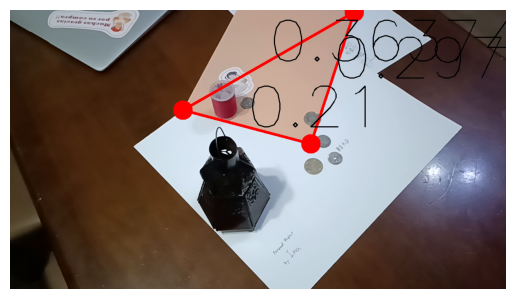

In [5]:
#save the image
cv2.imwrite('output.jpg', image)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [6]:
# Define a RotationMatrix class
# It includes the following attributes:
# -  3 angles defining the rotation matrix. (kappa, phi, omega)
# return the li,mi,ni (i=0,1,2) for te given angles
# 
class RotationMatrix:
    def __init__(self, omega: float, phi: float, kappa: float):
        self.kappa :float = kappa
        self.phi :float = phi
        self.omega :float = omega
        
        self.matrix_x= np.array([[1, 0, 0], [0, np.cos(omega), -np.sin(omega)], [0, np.sin(omega), np.cos(omega)]])
        self.matrix_y= np.array([[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]])
        self.matrix_z= np.array([[np.cos(kappa), -np.sin(kappa), 0], [np.sin(kappa), np.cos(kappa), 0], [0, 0, 1]])
        self.matrix = self.matrix_z @ self.matrix_y @ self.matrix_x

        self.dmatrix_x_domega= np.array([[0, 0, 0], [0, -np.sin(omega), -np.cos(omega)], [0, np.cos(omega), -np.sin(omega)]])
        self.dmatrix_y_dphi= np.array([[-np.sin(phi), 0, np.cos(phi)], [0, 0, 0], [-np.cos(phi), 0, -np.sin(phi)]])
        self.dmatrix_z_dkappa= np.array([[-np.sin(kappa), -np.cos(kappa), 0], [np.cos(kappa), -np.sin(kappa), 0], [0, 0, 0]])
        self.matrix_domega = self.matrix_z @ self.matrix_y @ self.dmatrix_x_domega
        self.matrix_dphi = self.matrix_z @ self.dmatrix_y_dphi @ self.matrix_x
        self.matrix_dkappa = self.dmatrix_z_dkappa @ self.matrix_y @ self.matrix_x

        # self.li = self.matrix[:,0]
        # self.mi = self.matrix[:,1]
        # self.ni = self.matrix[:,2]
      
        
    def __str__(self):
        return f'omega={self.omega}, phi={self.phi}, kappa={self.kappa}\nMatrix={self.matrix}'
    def __repr__(self):
        return self.matrix.__repr__()

# Define a DistanceConstraint class
# It includes the following attributes:
# -  2 points \in R3 defining the distance constraint. (p1, p2)
# -  The distance between the 2 points. (d)
# return the partial derivatives of the distance constraint
#
class DistanceConstraint:
    def __init__(self, X1: np.array, X2: np.array, d: float):
        self.X1 = X1
        self.X2 = X2
        self.dX = X1-X2
        self.d = d
        self.error = self.dX[0]**2 + self.dX[1]**2 - d**2
        self.derror_dxy = np.array([[2*self.dX[0], -2*self.dX[0]],[2*self.dX[1], -2*self.dX[1]]])# [de/dx1, de/dx2], [de/dy1, de/dy2]
        
    def __str__(self):
        return f'error={self.error}'

# Define a ColinearityConstraint class
# It includes the following attributes:
# -  RotationMatrix object
# -  focal length (c)
# -  a pair of points \in R2  on the image and the corresponding 3d points \in R3. (p, X)
# return the partial derivatives of the colinearity constraint
#
class ColinearityConstraint:
    def __init__(self, rotation_matrix: RotationMatrix, c:float , p: np.array, X: np.array):
        self.rotation_matrix = rotation_matrix
        self.p = p
        self.X = X
        self.c= c
        self.inv_c = 1/c
        self.errorXY =np.array([np.dot(rotation_matrix.matrix[:,0], X) - p[0]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X),
                                 np.dot(rotation_matrix.matrix[:,1], X) - p[1]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X)]) # [eX, eY]
        self.derrorXY_dxyz = np.array([[ self.rotation_matrix.matrix[i,0] - p[0]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)],# [deX/dX, deX/dY, deX/dZ]
                                      [ self.rotation_matrix.matrix[i,1] - p[1]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)]])# [deY/dX, deY/dY, deY/dZ]
        # [deX/domega, deY/domega]
        self.derrorXY_domega = np.array([np.dot(self.rotation_matrix.matrix_domega[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_domega[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X)])
        # [deX/dphi, deY/dphi]
        self.derrorXY_dphi = np.array([np.dot(self.rotation_matrix.matrix_dphi[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_dphi[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X)])
        # [deX/dkappa, deY/dkappa]
        self.derrorXY_dkappa = np.array([np.dot(self.rotation_matrix.matrix_dkappa[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_dkappa[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X)])

    def __str__(self):
        return f'errorX={self.errorXY[0]}\n\terrorY={self.errorXY[1]}'


In [7]:
for i in range(10):
    r=random.random()*2*np.pi
    omega,phi,kappa = r-0.5,  2*(r-0.5),3*(r-0.5)
    R=RotationMatrix(omega,phi,kappa)
    R1=RotationMatrix(omega+np.pi,np.pi-phi,kappa+np.pi)
    r=[random.random() for i in range(3)]
    print(R.matrix@np.array(r)-R1.matrix@np.array(r))

[ 0.00000000e+00 -3.33066907e-16 -1.11022302e-16]
[-1.11022302e-16  3.33066907e-16 -5.55111512e-17]
[0.00000000e+00 2.77555756e-16 2.22044605e-16]
[ 0.00000000e+00 -5.55111512e-17 -1.11022302e-16]
[ 0.00000000e+00 -8.88178420e-16 -7.77156117e-16]
[-2.22044605e-16  3.33066907e-16  1.11022302e-16]
[ 2.77555756e-17 -1.11022302e-16 -5.55111512e-17]
[-4.44089210e-16  2.77555756e-16  2.22044605e-16]
[1.66533454e-16 2.22044605e-16 5.55111512e-17]
[ 5.55111512e-16  2.22044605e-16 -1.11022302e-16]


In [8]:
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D 

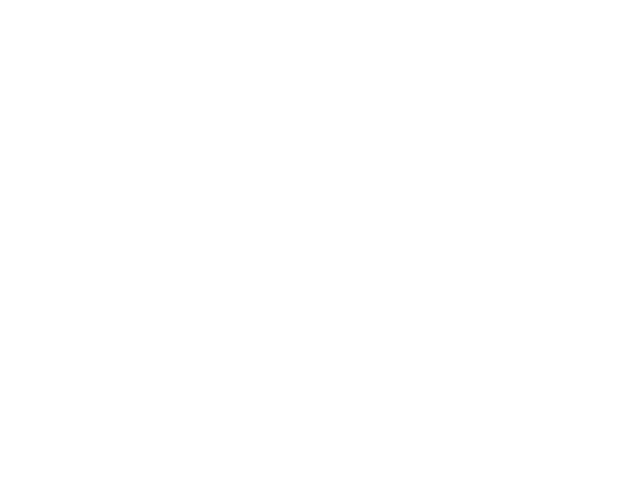

In [9]:


fig = plt.figure() 
ax = Axes3D(fig) 
  
# creating the plot 

xyz=R.matrix@np.array([0,0,1])
xyz1=R1.matrix@np.array([0,0,-1])
ax.plot([0,xyz[0]],[0, xyz[1]], zs=[0,xyz[2]])
ax.plot([0,xyz1[0]],[0, xyz1[1]], zs=[0,xyz1[2]])

#plot_geeks = ax.scatter(xs, ys, zs, color='green') 
  
# setting title and labels 
ax.set_title("3D plot") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_zlabel('z-axis') 
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
  
# displaying the plot 
plt.show() 

(-1.0, 1.0)

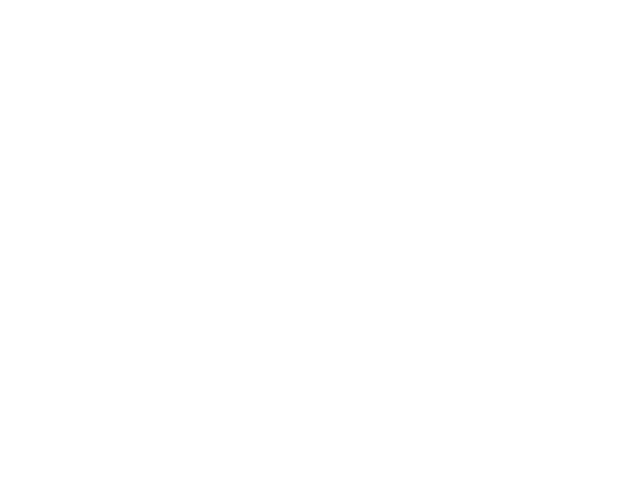

In [106]:


fig = plt.figure() 
ax = Axes3D(fig) 
  
# creating the plot 

xyz=R.matrix@np.array([0,0,1])
xyz1=R1.matrix@np.array([0,0,1])
ax.plot([0,xyz[0]],[0, xyz[1]], zs=[0,xyz[2]])
ax.plot([0,xyz1[0]],[0, xyz1[1]], zs=[0,xyz1[2]])

#plot_geeks = ax.scatter(xs, ys, zs, color='green') 
  
# setting title and labels 
ax.set_title("3D plot") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_zlabel('z-axis') 
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
  
# displaying the plot 
# plt.show() 

[[ 0.14007236 -0.80234716  0.58018857]
 [ 0.60853524  0.53199487  0.58878377]
 [-0.78106632  0.27059286  0.56277429]]
[[ 0.14007236 -0.80234716  0.58018857]
 [ 0.60853524  0.53199487  0.58878377]
 [-0.78106632  0.27059286  0.56277429]]


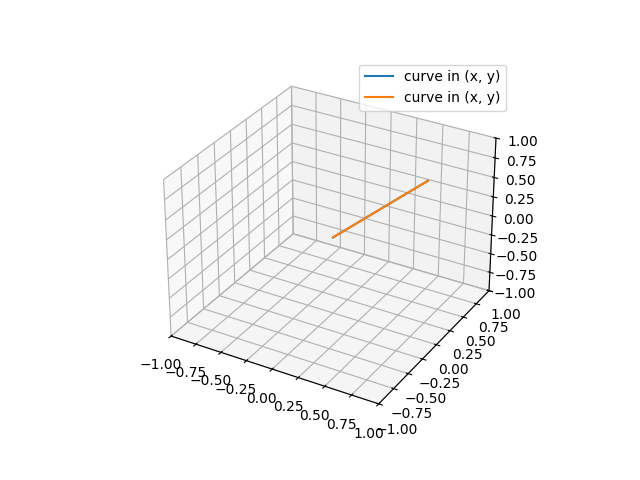

In [114]:
for i in range(10):
    continue
r=(random.random()-0.5)*2*np.pi
omega,phi,kappa = r,  2*r,3*r
R=RotationMatrix(omega,phi,kappa)
R1=RotationMatrix(omega+np.pi,np.pi-phi,kappa+np.pi)
#R1=RotationMatrix(omega,phi,kappa)
ax = plt.figure().add_subplot(projection='3d')

xyz=R.matrix@np.array([0,0,1])
xyz1=R1.matrix@np.array([0,0,1])
ax.plot([0,xyz[0]],[0, xyz[1]], zs=[0,xyz[2]], zdir='z', label='curve in (x, y)')
ax.plot([0,xyz1[0]],[0, xyz1[1]], zs=[0,xyz1[2]], zdir='z', label='curve in (x, y)')
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
#print(R.matrix,R1.matrix)
print(R.matrix)
print(R1.matrix)

In [8]:
initialize=lambda x1, y1,y2,x3,y3,h,omega,phi,kappa: (np.array([[x1,y1,h],[x1,y2,h],[x3,y3,h]]), omega,phi,kappa)

In [9]:
#generate random variables for the 3d points
Xs,omega,phi,kappa=initialize(random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],-0.5,0,0,0)
#generate random variables for the 3d points
d_base=np.abs(random.random()*ds[0])
Xs,omega,phi,kappa=initialize(d_base,d_base,
                              d_base*1.5,d_base*1.5,
                              d_base*2,-0.5,0,0,0)
d_base=np.abs(random.random()*ds[0])+0.05
Xs,omega,phi,kappa=initialize(d_base,d_base,
                                d_base*1.5,d_base*1.5,
                                d_base*2,-0.5,d_base,d_base*2,d_base*3)

In [10]:
Xs,_,_,_=initialize(0.2,0.3,0.4,0.5,0.2,-0.5,0,0,0)
d_base=np.abs(random.random()*ds[0])
Xs,_,_,_=initialize(d_base,d_base,
                              d_base*1.5,d_base*1.5,
                              d_base*2,-0.5,0,0,0)

Xs,_,_,_=initialize(d_base,d_base,
                                d_base*1.5,d_base*1.5,
                                d_base*2,-0.5,d_base,d_base*2,d_base*3)

In [17]:
#generate random variables for the 3d points
Xs,omega,phi,kappa=initialize(random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],-random.random()*ds[0],
                              random.random()*np.pi,random.random()*np.pi*2,random.random()*np.pi*2)
                              

In [21]:
#generate random variables for the 3d points
Xs,omega,phi,kappa=initialize(0.5+random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],random.random()*ds[0]+0.80,
                              random.random()*ds[0],-0.52,
                              random.random()*np.pi,random.random()*np.pi*2,random.random()*np.pi*2)
                              

In [42]:
X1_random=0.4*(1+(random.random()-0.5)*0.25)
Y1_random=0.15*(1+(random.random()-0.5)*0.25)
Xs,omega,phi,kappa=initialize(X1_random,Y1_random,
                            Y1_random+ds[0],X1_random+ds[1],
                            Y1_random,-0.52,
                            2.0,random.random()*np.pi,random.random()*np.pi*0.5)


In [49]:
max_iter=300
b_collect=np.zeros((9,max_iter))
angle_collect=np.zeros((3,max_iter))
Xs_collect=np.zeros((3,3,max_iter))
#Xs_collect=np.zeros((3,3,max_iter*2))
dx_collect=np.zeros((9,max_iter))
det_collect=np.zeros((max_iter))

#print(Xs,omega,phi,kappa)
for iter in range(max_iter):
    if Xs[0,2]>0:
        #Xs=-Xs
        Xs[:,(1,2)]=-Xs[:,(1,2)]
    if Xs[1,1]-Xs[0,1]<0:
        Xs[:,0:2]=-Xs[:,0:2]
    
    #This process doesn't change the Rotation Matrix.
    while omega>np.pi:
        omega-=2*np.pi
    while omega< -np.pi:
        omega+=2*np.pi
    if omega<0:
        omega,phi,kappa=omega+np.pi,np.pi-phi,kappa+np.pi
    while phi>np.pi:
        phi-=2*np.pi
    while phi< -np.pi:
        phi+=2*np.pi
    while kappa>np.pi:
        kappa-=2*np.pi
    while kappa< -np.pi:
        kappa+=2*np.pi
    R=RotationMatrix(omega,phi,kappa)
    # if iter>0 and np.dot(R.matrix.T[2,:],Xs[0,:])<0 and np.dot(R.matrix.T[2,:],Xs[1,:])<0 and np.dot(R.matrix.T[2,:],Xs[2,:])<0  :
    #     print("pose inversion(1) activated.")
    #     phi+=np.pi
    #     kappa=-kappa
    #     R=RotationMatrix(omega,phi,kappa)
    distance_constraint=[DistanceConstraint(Xs[i%3],Xs[(i+1)%3],ds[i]) for i in range(3)]
    #colinearity_constraint=[ColinearityConstraint(R,c,ps[i]-ps0[i],Xs[i,:]) for i in range(3)]
    colinearity_constraint=[ColinearityConstraint(R,c,ps0[i]-ps[i],Xs[i,:]) for i in range(3)]
    

    A=np.zeros((9,9))
    b=np.zeros(9)

    indeces=[(0,1,5),(0,2,5),(3,4,5)]
    #attributing the partial derivatives to the matrix A and the error to the vector b
    #distance constraints
    for i in range(3):
        inv_d=1/distance_constraint[i].d
        for j in range(2):
            A[i,indeces[(i+j)%3][0]]+=distance_constraint[i].derror_dxy[0,j]*inv_d
            A[i,indeces[(i+j)%3][1]]+=distance_constraint[i].derror_dxy[1,j]*inv_d
        b[i]= - distance_constraint[i].error*inv_d
    
    # colinearity constraints
    for i in range(3):
        for j in range(2):
            A[3+2*i+j,indeces[i]] = colinearity_constraint[i].derrorXY_dxyz[j,0:3]
            A[3+2*i+j,6:9] = (colinearity_constraint[i].derrorXY_domega[j],colinearity_constraint[i].derrorXY_dphi[j],colinearity_constraint[i].derrorXY_dkappa[j])
            b[3+2*i+j] = - colinearity_constraint[i].errorXY[j]
    b_collect[:,iter]=b
    angle_collect[:,iter]=omega,phi,kappa
    det_collect[iter]= np.linalg.det(A)
    #Xs_collect[:,:,iter*2]=Xs
    Xs_collect[:,:,iter]=Xs

    dx=np.linalg.solve(A,b)
    alpha=0.1
    Xs[(0,1),0]+=dx[0]*alpha
    Xs[0,1]+=dx[1]*alpha
    Xs[1,1]+=dx[2]*alpha
    Xs[2,0]+=dx[3]*alpha
    Xs[2,1]+=dx[4]*alpha
    Xs[(0,1,2),2]+=dx[5]*alpha
    # if Xs[0,2]+dx[5]*alpha<0:
    #     Xs[(0,1,2),2]+=dx[5]*alpha
    # else:
    #     Xs[(0,1,2),2]-=dx[5]*alpha
    # #Xs_collect[:,:,iter*2+1]=Xs

    omega+=dx[6]*alpha
    phi+=dx[7]  *alpha
    kappa+=dx[8]*alpha

    if  np.dot(b, b) <1e-3:#b[0]**2+b[1]**2+b[2]**2
        if np.dot(R.matrix.T[2,:],Xs[0,:])<0 and np.dot(R.matrix.T[2,:],Xs[1,:])<0 and np.dot(R.matrix.T[2,:],Xs[2,:])<0  :
            print("pose inversion(2) activated.")
            phi+=np.pi
            kappa=-kappa
            R=RotationMatrix(omega,phi,kappa)

    if iter%1==0:
        print(f'iteration {iter}')
        # for i in range(3):
        #     print("\t",distance_constraint[i])
        # for i in range(3):
        #     print("\t",colinearity_constraint[i])
        # print("\t",Xs,omega,phi,kappa)
        print(np.linalg.det(A),np.dot(R.matrix.T[2,:],Xs[0,:]), np.dot(R.matrix.T[2,:],Xs[1,:]), np.dot(R.matrix.T[2,:],Xs[2,:]))
    
    dx_collect[:,iter]=dx
    



iteration 0
0.013092146255006189 0.5959328647358446 0.6400513928993546 0.7354707623301775
iteration 1
0.01309214625500634 0.5959328647358357 0.6400513928993488 0.7354707623301686
iteration 2
0.013092146255006456 0.5959328647358278 0.6400513928993434 0.7354707623301608
iteration 3
0.013092146255006609 0.5959328647358207 0.6400513928993388 0.735470762330154
iteration 4
0.013092146255006688 0.5959328647358144 0.6400513928993344 0.7354707623301475
iteration 5
0.013092146255006851 0.5959328647358085 0.6400513928993306 0.7354707623301417
iteration 6
0.013092146255006968 0.5959328647358035 0.6400513928993272 0.7354707623301369
iteration 7
0.013092146255007027 0.5959328647357988 0.6400513928993241 0.7354707623301321
iteration 8
0.013092146255007073 0.5959328647357947 0.6400513928993212 0.735470762330128
iteration 9
0.013092146255007178 0.5959328647357909 0.6400513928993188 0.7354707623301242
iteration 10
0.013092146255007247 0.5959328647357875 0.6400513928993166 0.7354707623301209
iteration 11

In [55]:
with open(f'{image_path}_output.dat','a') as f:
    f.write(f'{Xs[0,0]:0.4f}, {Xs[0,1]:0.4f}, {Xs[1,1]:0.4f}, {Xs[2,0]:0.4f}, {Xs[2,1]:0.4f}, {Xs[0,2]:0.4f}\n')
    f.write(f'{omega:0.4f}, {phi:0.4f}, {kappa:0.4f}\n')
    f.write(', '.join([f'{b_collect[i,-1]:0.4f}'for i in range(9)])+'\n')
    

/var/folders/cn/yqnltnjd63l9dw00xky04wq40000gn/T/ipykernel_19868/530288331.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


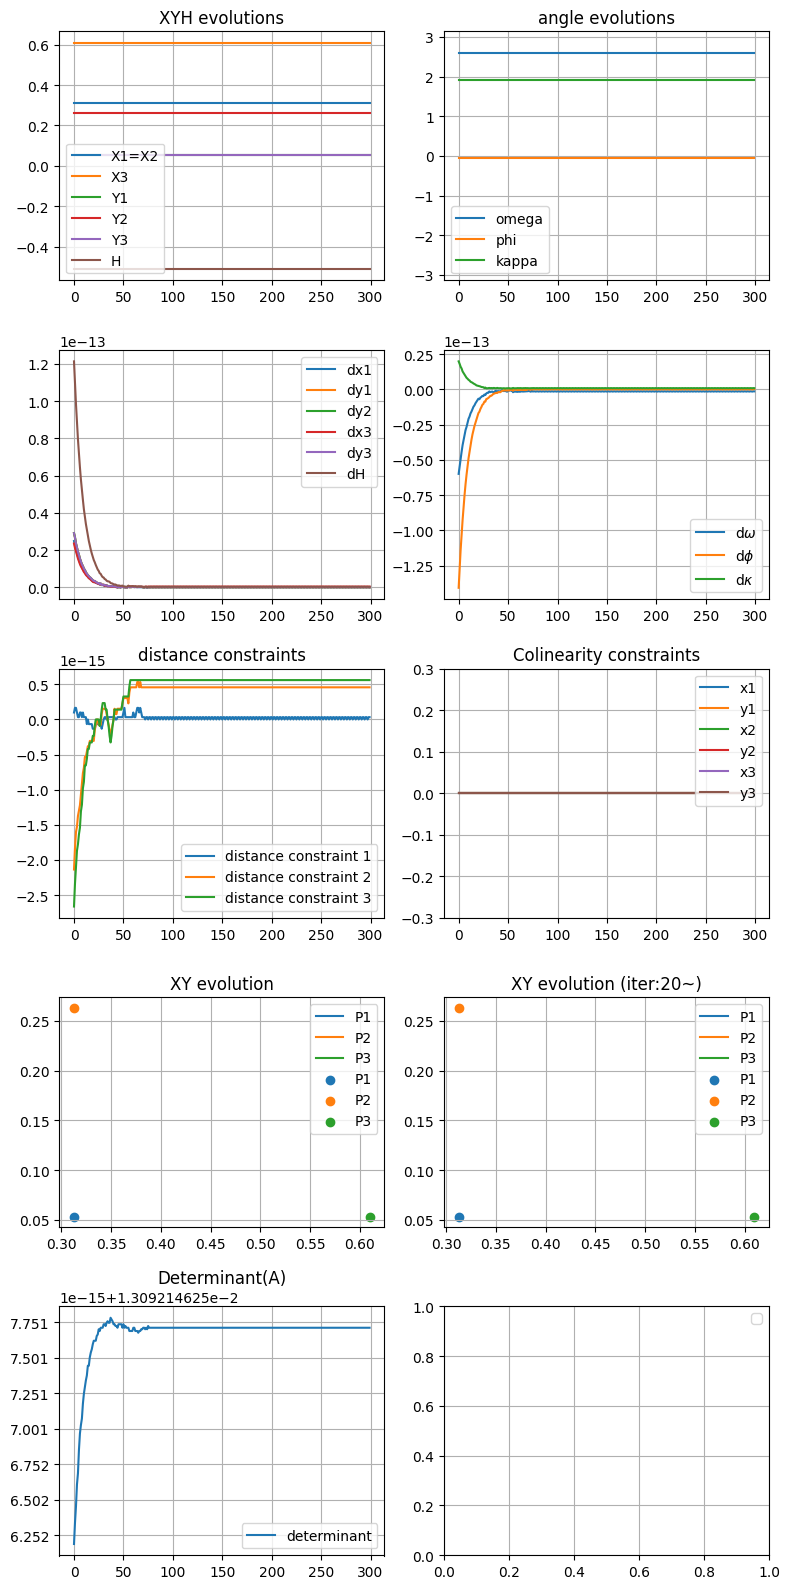

In [51]:

# Create a figure and subplots
fig, axs = plt.subplots(5, 2, figsize=(8, 16))

#plot the XYH evolutions(0,0)
ax = axs[0, 0]
ax.plot(Xs_collect[0,0,:],label='X1=X2')
ax.plot(Xs_collect[2,0,:],label='X3')
ax.plot(Xs_collect[0,1,:],label='Y1')
ax.plot(Xs_collect[1,1,:],label='Y2')
ax.plot(Xs_collect[2,1,:],label='Y3')
ax.plot(Xs_collect[0,2,:],label='H')
ax.set_title("XYH evolutions")


#plot the angle evolutions(0,1)
ax = axs[0, 1]
ax.plot(angle_collect[0,:],label='omega')
ax.plot(angle_collect[1,:],label='phi')
ax.plot(angle_collect[2,:],label='kappa')
ax.set_title("angle evolutions")
ax.set_ylim(-np.pi,np.pi)

#Illustrate the evolution of the dx (1,0)
ax = axs[1, 0]
ax.plot(dx_collect[0,:],label='dx1')
ax.plot(dx_collect[1,:],label='dy1')
ax.plot(dx_collect[2,:],label='dy2')
ax.plot(dx_collect[3,:],label='dx3')
ax.plot(dx_collect[4,:],label='dy3')
ax.plot(dx_collect[5,:],label='dH')

ax = axs[1, 1]
ax.plot(dx_collect[6,:],label=r'd$\omega$')
ax.plot(dx_collect[7,:],label=r'd$\phi$')
ax.plot(dx_collect[8,:],label=r'd$\kappa$')

#plot the distance constraints(2,0)
ax = axs[2, 0]
ax.plot(b_collect[0,:],label='distance constraint 1')
ax.plot(b_collect[1,:],label='distance constraint 2')
ax.plot(b_collect[2,:],label='distance constraint 3')
ax.set_title("distance constraints")

#plot the colinearity constraints(2,1)
ax = axs[2, 1]
ax.plot(b_collect[3,:],label='x1')
ax.plot(b_collect[4,:],label='y1')
ax.plot(b_collect[5,:],label='x2')
ax.plot(b_collect[6,:],label='y2')
ax.plot(b_collect[7,:],label='x3')
ax.plot(b_collect[8,:],label='y3')
ax.set_ylim(-0.3,0.3)
ax.set_title("Colinearity constraints")


#plot the colinearity constraints(2,1)
start_iter=20
for j in range(3):
    axs[3,0].plot(Xs_collect[j,0,:],Xs_collect[j,1,:],label=f'P{j+1}')# Plot the 1st graph on the right subplot
    axs[3,1].plot(Xs_collect[j,0,start_iter:],Xs_collect[j,1,start_iter:],label=f'P{j+1}')# Plot the second graph on the right subplot
for i in range(2):
    for j in range(3):
        axs[3,i].scatter(Xs_collect[j,0,-1],Xs_collect[j,1,-1],label=f'P{j+1}')
    axs[3,i].set_aspect('equal') # Fix aspect ratio
axs[3,0].set_title('XY evolution')
axs[3,1].set_title(f'XY evolution (iter:{start_iter}~)')

#plot the colinearity constraints(2,1)
ax = axs[4, 0]
ax.plot(det_collect,label='determinant')
ax.set_title("Determinant(A)")


# Plot some data on each subplot
for j in range(2):
    for i in range(5):
        ax = axs[i, j]
        ax.grid()
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
np.linalg.norm(b)

1.5997594010428072e-15

In [452]:
for i in range(3):
    print(distance_constraint[i])
for i in range(3):
    print(colinearity_constraint[i])

error=-5.680198779077494e-07
error=4.535235614083755e-06
error=4.807420946800756e-06
errorX=-0.03689124790853491
	errorY=0.02363569782358616
errorX=-0.13131194361948226
	errorY=-0.11600519236012327
errorX=-0.03591655888417018
	errorY=0.014882365621526396


In [41]:
num_cases_max=100
#num_cases_max=6000
num_cases=50
b_collect=np.zeros((9,num_cases))
angle_collect=np.zeros((3,num_cases))
Xs_collect=np.zeros((3,3,num_cases))
dXs_collect=np.zeros((9,num_cases))
det_collect=np.zeros((num_cases))

case_count=0

for i_case in range(num_cases_max):
    if case_count>=num_cases:
        break
    print(f'case {i_case}')
    # initialize with random values
    # generate random variables for the 3d points
    d_base=np.abs(random.random()*ds[0])
    Xs,omega,phi,kappa=initialize(d_base,d_base,
                                d_base*1.5,d_base*1.5,
                                d_base*2,-0.5,d_base,d_base*2,d_base*3)
    # ###initialize with completely random values
    Xs,omega,phi,kappa=initialize(random.random()*ds[0],random.random()*ds[0],
                                random.random()*ds[0],random.random()*ds[0],
                                random.random()*ds[0],-random.random()*ds[0],
                                random.random()*np.pi,random.random()*np.pi*2,random.random()*np.pi)
    X1_random=0.4*(1+(random.random()-0.5)*0.25)
    Y1_random=0.15*(1+(random.random()-0.5)*0.25)
    Xs,omega,phi,kappa=initialize(X1_random,Y1_random,
                                Y1_random+ds[0],X1_random+ds[1],
                                Y1_random,-0.52,
                                2.0,random.random()*np.pi,random.random()*np.pi*0.5)


    # ### initialize with an appropriate value
    # Xs,omega,phi,kappa=initialize(0.035,0.09,
    #                             0.25,0.31,
    #                             0.094,-0.33,5.7,3.6,2.6)
    # ### initialize with another value
    # Xs,omega,phi,kappa=initialize(-0.010, -0.29,
    #                             -0.13, 0.26, 
    #                             -0.29, -0.26, 0.54, 3.5, 2.5)
                                                        

    max_iter=600

    #print(Xs,omega,phi,kappa)
    for iter in range(max_iter):
        if Xs[0,2]>0:
            #Xs=-Xs
            Xs[:,(1,2)]=-Xs[:,(1,2)]
        if Xs[0,2]<-0.7:
            Xs[:,2]=-0.52
        if Xs[1,1]-Xs[0,1]<0:
            Xs[:,0:2]=-Xs[:,0:2]
        
        #This process doesn't change the Rotation Matrix.
        while omega>np.pi:
            omega-=2*np.pi
        while omega< -np.pi:
            omega+=2*np.pi
        if omega<0:
            omega,phi,kappa=omega+np.pi,np.pi-phi,kappa+np.pi
        while phi>np.pi:
            phi-=2*np.pi
        while phi< -np.pi:
            phi+=2*np.pi
        while kappa>np.pi:
            kappa-=2*np.pi
        while kappa< -np.pi:
            kappa+=2*np.pi
        phi=np.abs(phi)
        R=RotationMatrix(omega,phi,kappa)
        distance_constraint=[DistanceConstraint(Xs[i%3],Xs[(i+1)%3],ds[i]) for i in range(3)]
        #colinearity_constraint=[ColinearityConstraint(R,c,ps[i]-ps0[i],Xs[i,:]) for i in range(3)]
        colinearity_constraint=[ColinearityConstraint(R,c,ps0[i]-ps[i],Xs[i,:]) for i in range(3)]
        

        A=np.zeros((9,9))
        b=np.zeros(9)

        indeces=[(0,1,5),(0,2,5),(3,4,5)]
        #attributing the partial derivatives to the matrix A and the error to the vector b
        #distance constraints
        for i in range(3):
            inv_d=1/distance_constraint[i].d
            for j in range(2):
                A[i,indeces[(i+j)%3][0]]+=distance_constraint[i].derror_dxy[0,j]*inv_d
                A[i,indeces[(i+j)%3][1]]+=distance_constraint[i].derror_dxy[1,j]*inv_d
            b[i]= - distance_constraint[i].error*inv_d
        
        # colinearity constraints
        for i in range(3):
            for j in range(2):
                A[3+2*i+j,indeces[i]] = colinearity_constraint[i].derrorXY_dxyz[j,0:3]
                A[3+2*i+j,6:9] = (colinearity_constraint[i].derrorXY_domega[j],colinearity_constraint[i].derrorXY_dphi[j],colinearity_constraint[i].derrorXY_dkappa[j])
                b[3+2*i+j] = - colinearity_constraint[i].errorXY[j]

        
        dx=np.linalg.solve(A,b)
        # Renew the variables.
        alpha=0.1
        Xs[(0,1),0]+=dx[0]*alpha
        Xs[0,1]+=dx[1]*alpha
        Xs[1,1]+=dx[2]*alpha
        Xs[2,0]+=dx[3]*alpha
        Xs[2,1]+=dx[4]*alpha
        Xs[(0,1,2),2]+=dx[5]*alpha
        
        omega+=dx[6]*alpha
        phi+=dx[7]  *alpha
        kappa+=dx[8]*alpha


        if iter%20==0:
            print(f'\riteration {iter}',end='')
        
        # Verify the convergence and other conditions
        r=np.dot(dx,dx)
        if r<1.0e-8:
            if np.linalg.det(A)<0:
                print(f'\riteration {iter} det(A)<0',end='')
                break
            elif np.dot(R.matrix.T[2,:],Xs[0,:])<0 or np.dot(R.matrix.T[2,:],Xs[1,:])<0 or np.dot(R.matrix.T[2,:],Xs[2,:])<0:
                print(f'\riteration {iter} converged',end='')
                break
        if r<1.0e-16:
            if np.linalg.det(A)<0:
                print(f'\riteration {iter} det(A)<0',end='')
                break
            elif np.dot(R.matrix.T[2,:],Xs[0,:])<0 or np.dot(R.matrix.T[2,:],Xs[1,:])<0 or np.dot(R.matrix.T[2,:],Xs[2,:])<0:
                print(f'\riteration {iter} converged',end='')
                break
            # Convergence check
            if np.dot(b,b)<1.0e-16:
                print(f'\riteration {iter} converged',end='')
                break
    
    #print('\r',b)
    print()
    
    # verify positive definiteness
    if np.linalg.det(A)<0:
        print(f'\rDet(A)<0')
        continue
    
    if np.dot(R.matrix.T[2,:],Xs[0,:])<0 or np.dot(R.matrix.T[2,:],Xs[1,:])<0 or np.dot(R.matrix.T[2,:],Xs[2,:])<0:
        print(f'\rFacing wrong side.')
        continue
    # Convergence check
    if np.dot(b,b)>0.001:
        print(f'\rNot converged')
        continue
    print(f'\r{case_count} converged')
    Xs_collect[:,:,case_count]=Xs
    dXs_collect[:,case_count]=dx
    b_collect[:,case_count]=b.copy()
    angle_collect[:,case_count]=omega,phi,kappa
    det_collect[case_count]= np.linalg.det(A)
    
    case_count+=1

    

case 0
iteration 580
Not converged
case 1
iteration 580
Facing wrong side.
case 2
iteration 580
Facing wrong side.
case 3
iteration 580
Not converged
case 4
iteration 580
Not converged
case 5
iteration 580
Not converged
case 6
iteration 580
Not converged
case 7
iteration 580
Not converged
case 8
iteration 580
Not converged
case 9
iteration 580
Not converged
case 10
iteration 580
Det(A)<0
case 11
iteration 580
Not converged
case 12
iteration 580
Det(A)<0
case 13
iteration 580
Not converged
case 14
iteration 580
Det(A)<0
case 15
iteration 580
Det(A)<0
case 16
iteration 580
Det(A)<0
case 17
iteration 580
Not converged
case 18
iteration 580
Not converged
case 19
iteration 580
Facing wrong side.
case 20
iteration 580
Facing wrong side.
case 21
iteration 580
Not converged
case 22
iteration 580
Not converged
case 23
iteration 580
Not converged
case 24
iteration 580
Not converged
case 25
iteration 580
Not converged
case 26
iteration 580
Det(A)<0
case 27
iteration 580
Facing wrong side.
case 28

In [38]:
b,np.dot(b,b)

(array([ 1.65211760e-16, -2.44177460e-15, -3.08395285e-15, -2.71767419e-02,
         1.42310364e-03, -2.80763971e-02, -4.58294631e-03, -2.85021938e-02,
         6.33016470e-03]),
 0.002402334033645206)

In [33]:
Xs

array([[ 0.31251582,  0.05283903, -0.51137197],
       [ 0.31251582,  0.26283903, -0.51137197],
       [ 0.60951582,  0.0528391 , -0.51137197]])

In [40]:
case_count

0

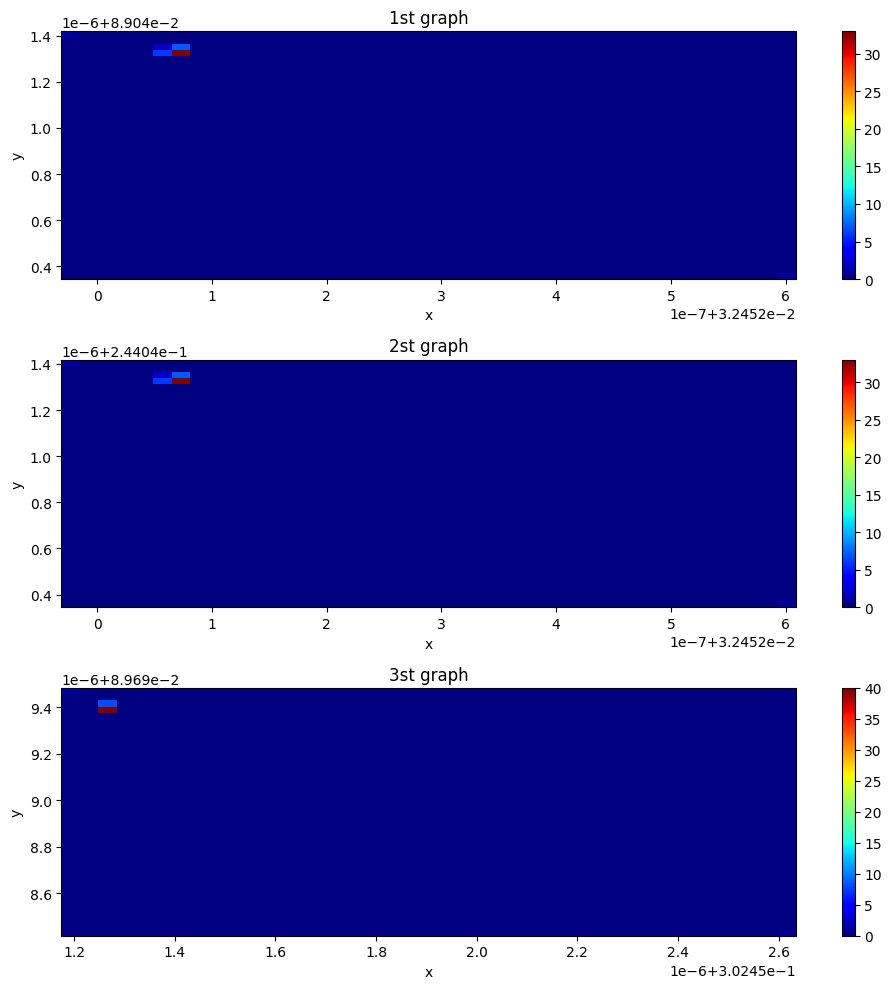

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(311)

H = ax.hist2d(Xs_collect[0,0,:],Xs_collect[0,1,:], bins=40, cmap=cm.jet)
ax.set_title('1st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)

ax = fig.add_subplot(312)

H = ax.hist2d(Xs_collect[1,0,:],Xs_collect[1,1,:], bins=40, cmap=cm.jet)
ax.set_title('2st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)

ax = fig.add_subplot(313)

H = ax.hist2d(Xs_collect[2,0,:],Xs_collect[2,1,:], bins=40, cmap=cm.jet)
ax.set_title('3st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)
fig.tight_layout()
plt.show()

In [18]:
R.matrix.T@Xs[0],R.matrix.T@Xs[1],R.matrix.T@Xs[2],(b_collect*b_collect).sum(axis=0)[-1]

(array([ 0.03847183, -0.15504633,  0.33971709]),
 array([ 0.13950271, -0.06189556,  0.41141572]),
 array([-0.16582708, -0.01822658,  0.45126221]),
 1.0513651314662096e-18)

when wrong initialization
(array([-0.04128355,  0.16619236,  0.34825699]),
 array([-0.09665554,  0.04284078,  0.27247195]),
 array([0.16722164, 0.01833527, 0.43522747]))

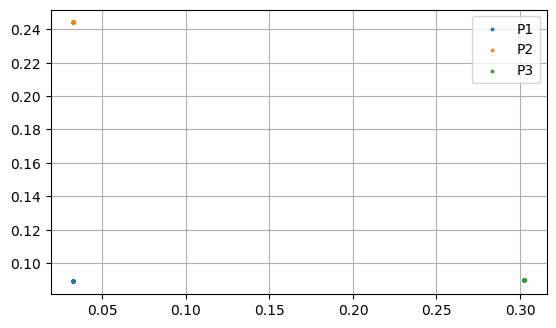

In [19]:
# illustrate the 3d points Xs on xy plane
plt.scatter(Xs_collect[0,0,:]     , Xs_collect[0,1,:],label='P1',s=3)
plt.scatter(Xs_collect[1,0,:], Xs_collect[1,1,:],label='P2',s=3)
plt.scatter(Xs_collect[2,0,:], Xs_collect[2,1,:],label='P3',s=3)
plt.grid()
# fix the aspect ration
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


In [20]:
# export collects in a csv format

df=pd.DataFrame(columns=['X1','Y1','Y2','X3','Y3','H','omega','phi','kappa']+[f'b{i+1}' for i in range(9)] +['det'])
precision=8
Xs_collect=Xs_collect.round(precision)
df["X1"]=Xs_collect[0,0,:]
df["Y1"]=Xs_collect[0,1,:]
df["Y2"]=Xs_collect[1,1,:]
df["X3"]=Xs_collect[2,0,:]
df["Y3"]=Xs_collect[2,1,:]
df["H"]=Xs_collect[0,2,:]
df["omega"]=angle_collect[0,:]
df["phi"]=angle_collect[1,:]
df["kappa"]=angle_collect[2,:]
df.round(precision)
for i in range(9):
    df[f'b{i+1}']=b_collect[i,:]
df["det"]=det_collect
# add a column for the x increment
for i in range(9):
    df[f'dX{i+1}']=dXs_collect[i,:]

# add a column of the square error (b@b)
df["SE"]=(b_collect*b_collect).sum(axis=0)

#df.to_csv("output.csv")

In [21]:
df.to_csv("output.csv")

In [22]:
display(df)

,X1,Y1,Y2,X3,Y3,H,omega,phi,kappa,b1,...,dX1,dX2,dX3,dX4,dX5,dX6,dX7,dX8,dX9,SE
0,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,-4.710291e-11,...,-1.325789e-09,-4.543840e-10,-4.779355e-10,-3.343511e-09,-1.024886e-09,4.161059e-09,2.743408e-09,-7.112392e-09,1.787965e-10,4.515419e-17
1,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,1.644858e-10,...,3.779671e-10,2.165579e-09,2.247822e-09,-2.683134e-10,2.106498e-09,5.852620e-09,-1.671947e-09,-6.103499e-09,-2.769704e-10,4.871553e-17
2,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,6.490216e-12,...,4.033002e-10,1.682249e-09,1.685494e-09,-1.414043e-09,1.681915e-09,4.643900e-09,-3.115669e-10,-7.179064e-09,3.611521e-10,6.174570e-17
3,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,-1.306885e-12,...,-4.997864e-10,2.272980e-09,2.272327e-09,-2.056118e-09,2.219575e-09,2.522906e-09,-5.435332e-09,-5.606498e-09,5.731236e-10,1.683149e-17
4,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,1.552723e-12,...,-6.359981e-10,1.003437e-09,1.004213e-09,-2.611494e-09,1.012379e-09,2.183346e-09,-5.033738e-09,-6.906051e-09,6.313096e-10,3.598595e-17
5,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,3.842848e-10,...,3.139646e-09,-4.235574e-09,-4.043431e-09,3.554442e-09,-4.336724e-09,1.022391e-09,-1.222513e-09,-3.387298e-10,-2.214144e-10,9.003003e-17
6,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,2.931579e-09,...,1.245818e-09,2.005339e-09,3.471128e-09,3.643753e-09,1.726267e-09,-1.932801e-09,-8.728811e-10,-3.456492e-09,2.201816e-09,8.463175e-17
7,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,-1.590343e-11,...,-1.673083e-10,2.669435e-09,2.661483e-09,-1.886636e-09,2.305403e-09,4.217680e-09,-3.456127e-09,-6.545068e-09,6.286039e-10,3.060393e-17
8,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,5.460462e-11,...,1.899436e-09,-5.343343e-09,-5.316041e-09,1.933388e-09,-5.348855e-09,1.647583e-09,4.174945e-10,5.279686e-11,-8.784398e-11,8.178001e-17
9,0.032452,0.089041,0.244041,0.302451,0.089699,-0.363243,2.473671,0.013877,2.431538,1.589880e-11,...,1.733878e-09,3.150418e-09,3.158367e-09,1.672640e-09,3.145744e-09,-2.970695e-09,-3.038381e-09,-5.569944e-09,1.679040e-10,1.456569e-17


In [444]:
for i,det in enumerate(det_collect):
    if det>0:
        print(i,det)

0 0.004549948914507111
1 0.0045499488717337415
2 0.004549948914529225
3 0.004549948926046412
4 0.00454994877691765
5 0.004549948849039614
6 0.004549948699738789
7 0.004549949028682431
8 0.0045499490990040395
9 0.0045499489110637755
10 0.004549948912908988
11 0.004549948880417569
12 0.004549948852012999
13 0.0045499488230928
14 0.004549948917000305
15 0.004549948897073904
16 0.004549948907005668
17 0.00454994883163821
18 0.0045499489336520895
19 0.004549948905342946
20 0.004549948901633831
21 0.00454994913333457
22 0.004549948915391012
23 0.004549948907133478
24 0.00454994872263459
25 0.004549948938903836
26 0.00454994889378873
27 0.004549948815231806
28 0.00454994879125696
29 0.004549948914957241
30 0.004549948814573884
31 0.004549948902701378
32 0.004549949064304773
33 0.004549948702408299
34 0.004549948738247471
35 0.0045499489233595215
36 0.004549948945024554
37 0.004549949013286056
38 0.004549948854159897
39 0.0045499489585082535
40 0.004549948948353901
41 0.004549948871246046
42 0